In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
# data dir
train_dir = "/ghome/group05/mcv/datasets/C3/MIT_large_train/train"
test_dir = "/ghome/group05/mcv/datasets/C3/MIT_large_train/test"

# sample image visulization

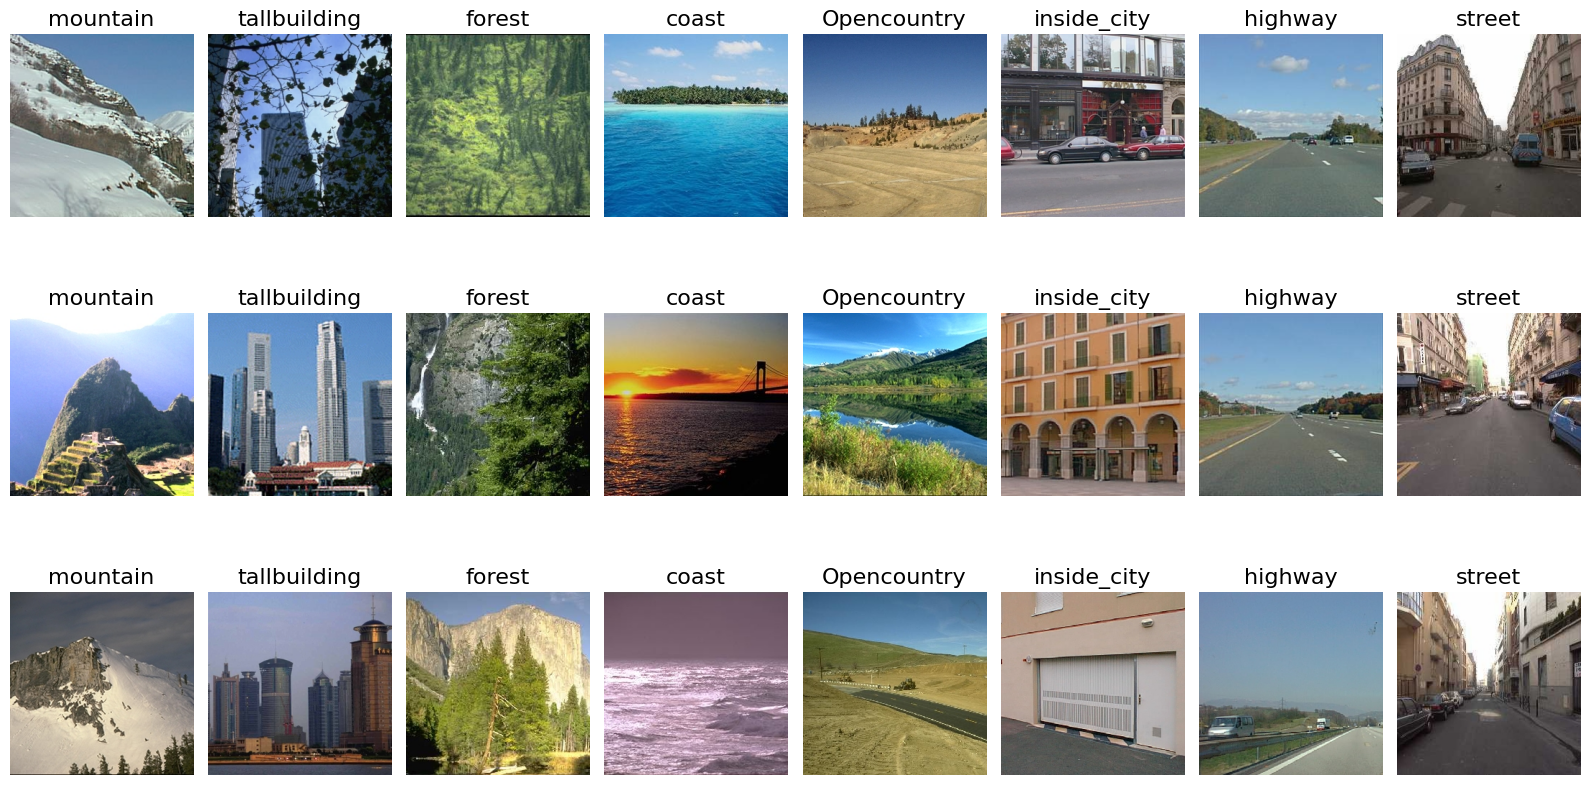

In [3]:
def get_random_images(dataset_dir: str, class_name: str, num_images=1):
    class_dir = os.path.join(dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, num_images)
    return [os.path.join(class_dir, img) for img in random_images]


# Path to your dataset directory

# Number of random images per class
num_random_images = 3

# List of class names (assuming your class names are the subdirectory names)
class_names = os.listdir(train_dir)

# Create a Matplotlib figure with subplots
fig, axes = plt.subplots(3, 8, figsize=(16, 9))

for i, class_name in enumerate(class_names):
    random_images = get_random_images(train_dir, class_name, num_random_images)

    for j, image_path in enumerate(random_images):
        image = Image.open(image_path)
        axes[j, i].imshow(image)
        axes[j, i].set_title(class_name, fontsize=16)
        axes[j, i].axis("off")

plt.tight_layout()
# plt.title("Sample images of each class")
plt.show()

# class distribution 

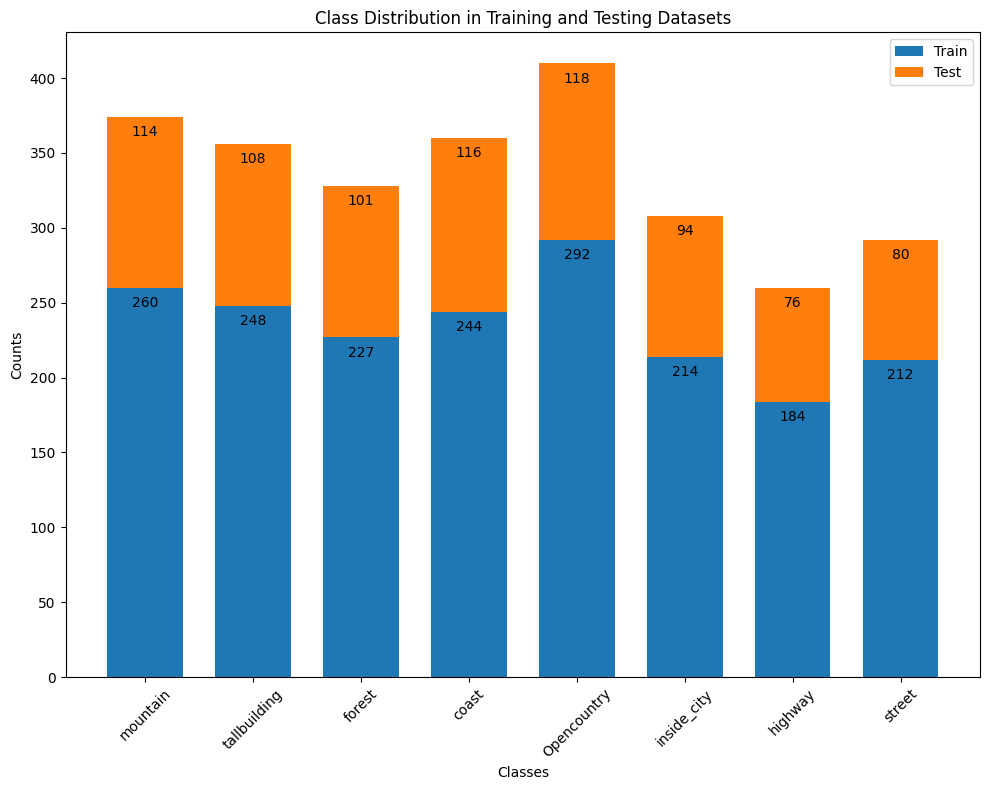

In [5]:
def get_class_distribution(dir_path):
    class_distribution = {}
    for folder in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, folder)
        class_distribution[folder] = len(os.listdir(folder_path))
    return class_distribution


# Get the class distributions for training and testing datasets
train_class_distribution = get_class_distribution(train_dir)
test_class_distribution = get_class_distribution(test_dir)

# Prepare data for plotting
classes = train_class_distribution.keys()
train_counts = [train_class_distribution[cls] for cls in classes]
test_counts = [test_class_distribution.get(cls, 0) for cls in classes]
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.7  # Increased bar width
index = range(len(classes))

bar1 = plt.bar(index, train_counts, bar_width, label="Train")
bar2 = plt.bar(index, test_counts, bar_width, bottom=train_counts, label="Test")

# Add the counts for training bars
for bar in bar1:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0, yval-15, int(yval), va="bottom", ha="center"
    )

# Add the counts for testing bars
for bar, test_count in zip(bar2, test_counts):
    yval = bar.get_y() + bar.get_height()
    if test_count > 0:  # Only display if test count is non-zero
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval-15,
            int(test_count),
            va="bottom",
            ha="center",
        )

plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Class Distribution in Training and Testing Datasets")
plt.xticks(index, classes, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# image feature analysis 

### 1. channel distribution 

In [7]:
mean_values = {cls: {"R": [], "G": [], "B": []} for cls in class_names}

for cls in class_names:
    class_folder = os.path.join(train_dir, cls)
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Splitting the channels
        R, G, B = cv2.split(image)

        # Calculating the mean for each channel and storing it
        mean_values[cls]["R"].append(np.mean(R))
        mean_values[cls]["G"].append(np.mean(G))
        mean_values[cls]["B"].append(np.mean(B))



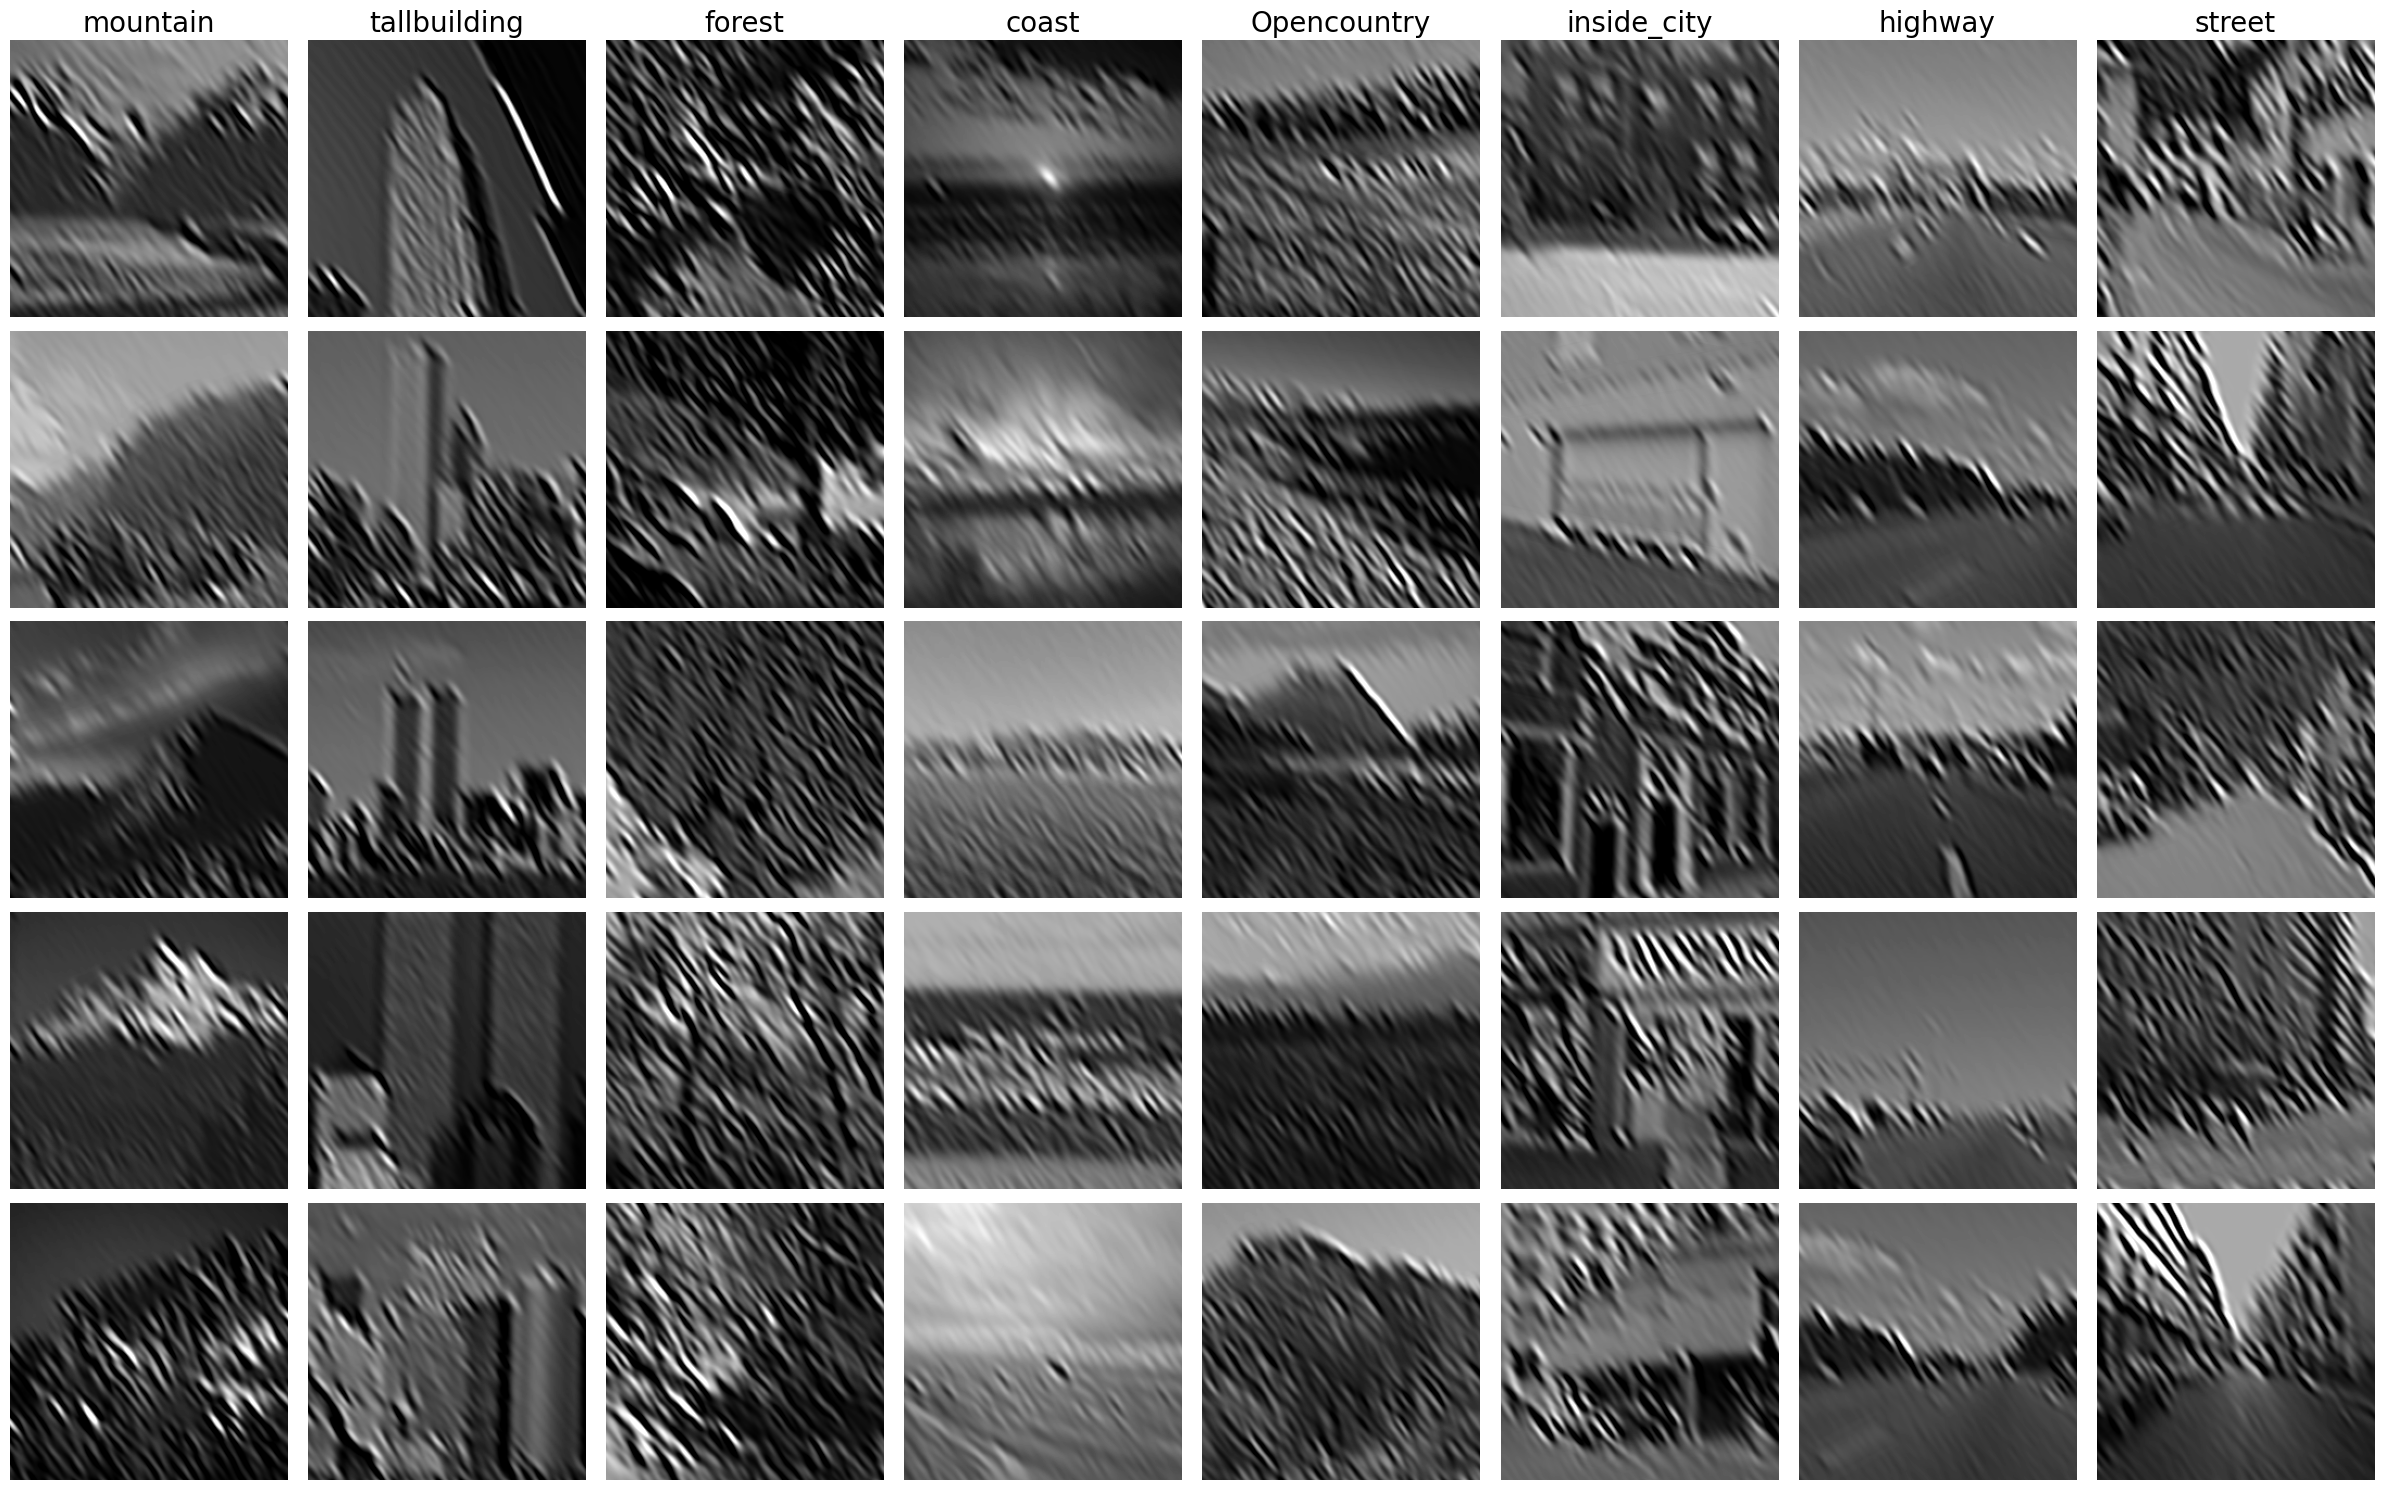

In [8]:
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 5):
        params = {
            "ksize": (ksize, ksize),
            "sigma": 4.0,
            "theta": theta,
            "lambd": 10.0,
            "gamma": 0.5,
            "psi": 0,
            "ktype": cv2.CV_32F,
        }
        kern = cv2.getGaborKernel(**params)
        kern /= 1.5 * kern.sum()
        filters.append((kern, params))
    return filters[-1]  # Return only the last filter


def process(img, filter):
    kern, params = filter
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
    return fimg


def plot_gabor_responses(class_names, image_paths, filter):
    num_classes = len(class_names)
    num_images_per_class = 5  # Number of images to display per class

    # Create a subplot grid with one column for each class and five rows for the images
    fig, axes = plt.subplots(
        num_images_per_class,
        num_classes,
        figsize=(num_classes * 3, num_images_per_class * 3),
    )

    for i, class_name in enumerate(class_names):
        for j, img_path in enumerate(image_paths[i]):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            res = process(img, filter)

            ax = axes[j, i]  # Locate subplot for image j of class i
            ax.imshow(res, cmap="gray")
            ax.axis("off")
            if j == 0:
                ax.set_title(
                    class_name,fontsize=20
                )  # Set the class name above the top image of each column

    plt.tight_layout()
    plt.show()


# Replace with your dataset path
filter = build_filters()
class_names = os.listdir(train_dir)  # List of class names
image_paths = []

# Select five random images per class
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)
    selected_images = random.sample(
        image_files, 5
    )  # Select five random images
    image_paths_for_class = [os.path.join(class_path, img) for img in selected_images]
    image_paths.append(image_paths_for_class)

plot_gabor_responses(class_names, image_paths, filter)

# statistical analysis

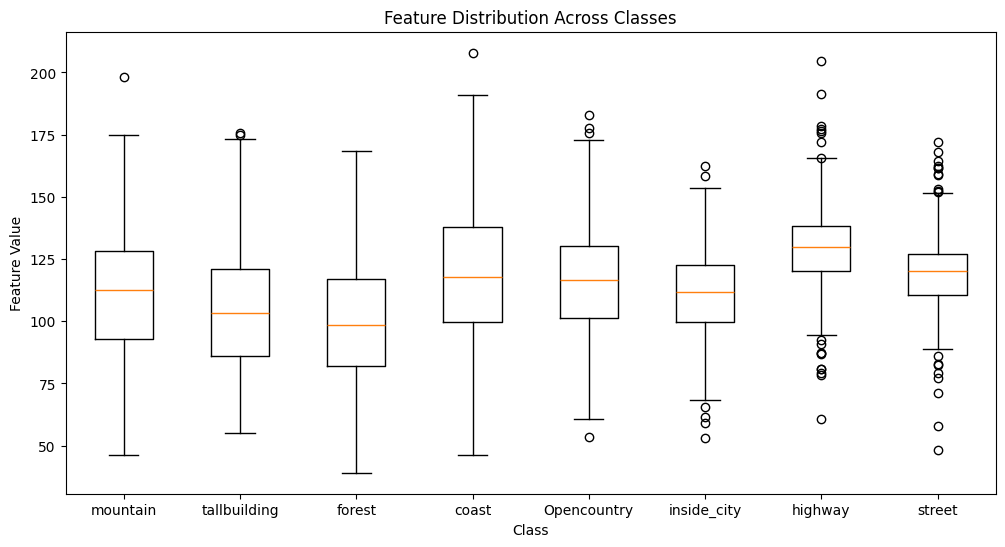

ANOVA results: F-value = 37.02622186628273 P-value = 8.259670601985011e-49


In [11]:

from scipy import stats


def extract_features(image):
    return np.mean(image), np.var(image)


def process_images(class_path):
    features = []
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        features.append(extract_features(img))
    return features




all_features = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    all_features[class_name] = process_images(class_path)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
feature_means = {
    class_name: [f[0] for f in features]
    for class_name, features in all_features.items()
}
ax.boxplot(feature_means.values(), labels=feature_means.keys())
ax.set_title("Feature Distribution Across Classes")
ax.set_xlabel("Class")
ax.set_ylabel("Feature Value")
plt.show()

# Statistical Analysis (e.g., ANOVA)
# Flatten the feature list for ANOVA
flattened_data = [item for sublist in feature_means.values() for item in sublist]
labels = [
    [class_name] * len(features) for class_name, features in feature_means.items()
]
flattened_labels = [item for sublist in labels for item in sublist]

f_val, p_val = stats.f_oneway(
    *[feature_means[class_name] for class_name in class_names]
)
print("ANOVA results: F-value =", f_val, "P-value =", p_val)